EuroSAT classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!wget https://madm.dfki.de/files/sentinel/EuroSAT.zip

In [3]:
%%capture
!ls
!unzip EuroSAT.zip

In [4]:
#Importing necessary libraries 
from tensorflow import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import resnet50
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import os
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint

In [5]:
# Load the ResNet50 model
resnet_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

94781440/94765736 [==============================] - 2s 0us/step


In [6]:
# checking the trainable status of the individual layers
for layer in resnet_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f438c0487d0> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f437a84b790> True
<keras.layers.convolutional.Conv2D object at 0x7f4379ff63d0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f4379f9d110> True
<keras.layers.core.activation.Activation object at 0x7f4379ff6990> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f4379fd9290> True
<keras.layers.pooling.MaxPooling2D object at 0x7f437068fa10> True
<keras.layers.convolutional.Conv2D object at 0x7f437069e210> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f43706a9d50> True
<keras.layers.core.activation.Activation object at 0x7f43706a2590> True
<keras.layers.convolutional.Conv2D object at 0x7f43706af050> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f437063e1d0> True
<keras.layers.core.activation.Activation object at 0x7f4370634290> True
<keras.layer

In [7]:
# Adding classifier on top of Convolution model
# create model 
model = models.Sequential()

In [8]:
# Add the resnet50 convolutional model
model.add(resnet_model)

# Adding new Layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

In [9]:
# summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1024)              8389632   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                10250     
                                                                 
Total params: 31,987,594
Trainable params: 31,934,474
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
# Fitting the CNN to the images(Image Augmentation, Image Preprocessing)
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( 
        rescale=1./255,
        shear_range=0.2,             
        zoom_range=0.2,              
        horizontal_flip=True,
        validation_split=0.2)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [11]:
train_data_dir = "2750/"
img_height, img_width = (64, 64)
batch_size = 32
seed = 42

# Slightly imbalanced, no stratified split, no k-fold, just test, val
# Also, no leakage with the splitting according to https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator/52372042#52372042

train_generator = train_datagen.flow_from_directory(    
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training', # set as training data
    seed=seed)

val_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation',# set as validation data
    seed=seed) 


Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [12]:
# lets dettermine dataset characteristics
print('Training Data: ',train_generator[0][0].shape)
print('Test Data: ',val_generator[0][0].shape)
# now shape of a single image
print('Shape of single image:', train_generator[0][0][0].shape)

Training Data:  (32, 64, 64, 3)
Test Data:  (32, 64, 64, 3)
Shape of single image: (64, 64, 3)


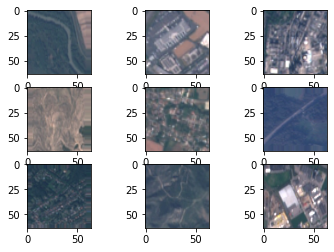

In [16]:
# create a grid of 3*3 images to visualize some of the imgaes in dataset
for i in range(0, 9):
    plt.subplot(330 + 1+ i)
    img = train_generator[0][0][i]
    plt.imshow(img)
    
# show the plot
plt.show()

In [17]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
!ls
!mkdir -p drive/MyDrive/eurosat-makeathon/eurosat_checkpoints
!ls

2750  drive  EuroSAT.zip  sample_data
2750  drive  EuroSAT.zip  sample_data


In [23]:
# checkpoint
dir = "drive/MyDrive/eurosat-makeathon/eurosat_checkpoints"
filename_best_val_acc="checkpoint_best_val_acc.hdf5"
filepath_best_val_acc = os.path.join(dir, filename_best_val_acc)

checkpoint = ModelCheckpoint(filepath_best_val_acc, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [24]:
# test saving data
# Train the model
history = model.fit_generator(
          train_generator, 
          steps_per_epoch=(32),
          epochs=1,
          callbacks=callbacks_list,
          validation_data=val_generator,
          validation_steps=(32))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


32/32 [==============================] - ETA: 0s - loss: 0.0683 - acc: 0.9775
Epoch 1: val_acc improved from -inf to 0.95833, saving model to drive/MyDrive/eurosat-makeathon/eurosat_checkpoints/checkpoint_best_val_acc.hdf5
32/32 [==============================] - 19s 603ms/step - loss: 0.0683 - acc: 0.9775 - val_loss: 0.1489 - val_acc: 0.9583


In [25]:
# Train the model
history = model.fit_generator(
          train_generator, 
          steps_per_epoch=(train_generator.samples/32),
          epochs=20,
          callbacks=callbacks_list,
          validation_data=val_generator,
          validation_steps=(val_generator.samples/32))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


675/675 [==============================] - ETA: 0s - loss: 0.0641 - acc: 0.9814
Epoch 1: val_acc improved from 0.95833 to 0.96537, saving model to drive/MyDrive/eurosat-makeathon/eurosat_checkpoints/checkpoint_best_val_acc.hdf5
675/675 [==============================] - 113s 168ms/step - loss: 0.0641 - acc: 0.9814 - val_loss: 0.1050 - val_acc: 0.9654
Epoch 2/20
675/675 [==============================] - ETA: 0s - loss: 0.0519 - acc: 0.9830
Epoch 2: val_acc did not improve from 0.96537
675/675 [==============================] - 109s 161ms/step - loss: 0.0519 - acc: 0.9830 - val_loss: 0.2529 - val_acc: 0.9413
Epoch 3/20
675/675 [==============================] - ETA: 0s - loss: 0.0526 - acc: 0.9830
Epoch 3: val_acc did not improve from 0.96537
675/675 [==============================] - 108s 160ms/step - loss: 0.0526 - acc: 0.9830 - val_loss: 0.1566 - val_acc: 0.9554
Epoch 4/20
675/675 [==============================] - ETA: 0s - loss: 0.0541 - acc: 0.9825
Epoch 4: val_acc did not improve

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


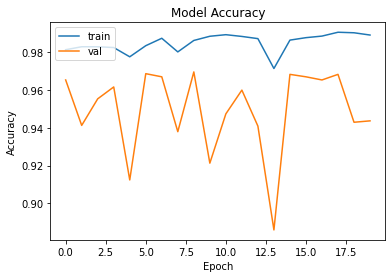

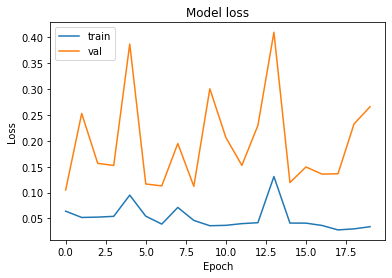

In [26]:
# Plotting the Loss and Classification Accuracy
model.metrics_names
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
# loading the best weights
from keras.models import load_model
model = load_model(filepath_best_val_acc)


In [28]:
# Visualizing the mapping of labels
val_generator.class_indices

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [29]:
# Confusion Matrix and Classification report
# creating 
Y_pred = model.predict_generator(val_generator, val_generator.samples//32 +1 )
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(val_generator.classes, y_pred)
#print(cm)

def cm2df(cm, labels):
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

df = cm2df(cm, ["AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial", "Pasture", "PermanentCrop", "Residential" ,"River", "SeaLake"])
print(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Confusion Matrix
                      AnnualCrop  Forest  HerbaceousVegetation  Highway  \
AnnualCrop                   580       0                     2        5   
Forest                         1     594                     2        0   
HerbaceousVegetation           5       1                   578        1   
Highway                        3       0                     1      484   
Industrial                     1       0                     1        1   
Pasture                       13       7                     8        0   
PermanentCrop                 14       0                     9        0   
Residential                    0       0                     0        0   
River                          5       1                     0        8   
SeaLake                        2       1                     0        0   

                      Industrial  Pasture  PermanentCrop  Residential  River  \
AnnualCrop                     0        2              3            0      4 

In [30]:


print('Classification Report')
target_names = ['AnnualCrop','Forest', 'HerbaceousVegetation', 'Highway',"Industrial", 'Pasture', 'PermanentCrop','Residential', 'River', 'SeaLake']
classifcn_report = classification_report(val_generator.classes, y_pred, target_names=target_names)
print(classifcn_report)



Classification Report
                      precision    recall  f1-score   support

          AnnualCrop       0.93      0.97      0.95       600
              Forest       0.98      0.99      0.99       600
HerbaceousVegetation       0.96      0.96      0.96       600
             Highway       0.97      0.97      0.97       500
          Industrial       0.98      0.96      0.97       500
             Pasture       0.96      0.92      0.94       400
       PermanentCrop       0.96      0.94      0.95       500
         Residential       0.96      0.99      0.98       600
               River       0.98      0.96      0.97       500
             SeaLake       0.99      0.99      0.99       600

            accuracy                           0.97      5400
           macro avg       0.97      0.96      0.97      5400
        weighted avg       0.97      0.97      0.97      5400

